## **Amazon Reviews: Machine Learning**
---
**Author:** Yuqi Liu

**Key Concepts**
- [Introduction](#Introduction)
- [Package Imports](#Package-Imports)
- [Load Data](#Load-Data)
- [Identify Dependent Variable](#Identify-Dependent-Variable)
- [Split Data](#Split-Data)
- [Class Balancing](#Class-Balancing)
- [Feature Extraction](#Feature-Extraction)
- [Preprocessing](#Preprocessing)
- [Model Fitting](#Model-Fitting)
- [Evaluation](#Evaluation)
- [Write Up](#Write-Up)

---
### Introduction

This model is built to classify positive and negative Amazon product reviews (e.g., see [Amazon Customer Reviews Dataset](https://s3.amazonaws.com/amazon-reviews-pds/readme.html) and [UCSD's Amazon review data](http://jmcauley.ucsd.edu/data/amazon/)).

### Package Imports

In [3]:
#!conda install statsmodels seaborn scikit-learn openpyxl -y
# or
# !pip install statsmodels seaborn scikit-learn openpyxl --quiet

# note: you may also want rpy2 (and R) to run the final examples in this script

Solving environment: done

# All requested packages already installed.



In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import math

from matplotlib import pyplot
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import tree
from sklearn.linear_model import LogisticRegression

### Load Data

Read in the Amazon reviews from an Excel file with multiple sheets and concatenate them into a single DataFrame:

In [2]:
rawDat = pd.concat(
    pd.read_excel('HP_RobotVacuum_AmazonReviews.xlsx', 
                  sheet_name = None),
    ignore_index = True)

rawDat

/Users/yuqiliu/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Date,Product,Stars,Title,Review
0,2015-08-10,iRobot Roomba 880 for Pets and Allergies,5,"Your house isn't ""Roomba Clean.""",You think your floors are clean? They're prob...
1,2015-09-09,iRobot Roomba 880 for Pets and Allergies,5,"Yes, it works. It works really, really well.","Yes, it really does work. We have dogs who sh..."
2,2015-11-18,iRobot Roomba 880 for Pets and Allergies,4,LOVE our roomba,Yes to everything everyone else said. LOVE ou...
3,2014-10-31,iRobot Roomba 880 for Pets and Allergies,5,My previous Roomba was working fine and I was ...,Yes there is a difference! I have had every m...
4,2014-06-16,iRobot Roomba 880 for Pets and Allergies,5,"Great product, does a fine job.",Yes the dust bin is a bit too small but what c...
...,...,...,...,...,...
4272,2015-09-30,"Samsung VR9000 Powerbot Robotic Vacuum, Airbor...",4,Great vacuum if you can get it to do what you ...,"Great vacuum overall. Very quiet, very powerfu..."
4273,2015-10-04,"Samsung VR9000 Powerbot Robotic Vacuum, Airbor...",4,"With the competition out there, this is a clos...",Compared with the Neato (we are a Neato family...
4274,2015-10-05,"Samsung VR9000 Powerbot Robotic Vacuum, Airbor...",5,"Love this vacuum, true time saver!","amazing suction, see a lot of fine dust"
4275,2015-08-23,"Samsung VR9000 Powerbot Robotic Vacuum, Airbor...",5,Powerful and Smart Vacuum!,Although I have never previously owned a robot...


In [3]:
rawDat.dtypes

Date       datetime64[ns]
Product            object
Stars               int64
Title              object
Review             object
dtype: object

### Identify Dependent Variable

In this case, we'll be predicting review rating using the "Stars" column:

In [9]:
rawDat.groupby('Stars').size()

Stars
1     343
2     222
3     311
4     715
5    2686
dtype: int64

A visual would probably help:

<AxesSubplot:xlabel='Stars', ylabel='count'>

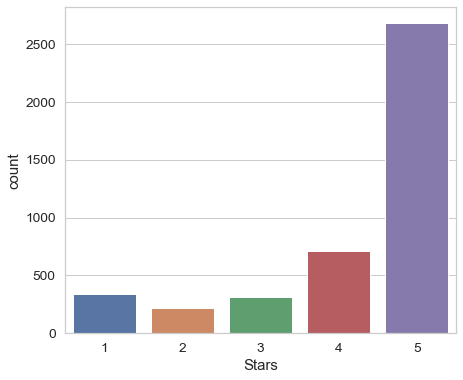

In [10]:
sns.set(rc = {'figure.figsize': (7, 6)},
        font_scale = 1.25) # increase text size on plots (e.g., axis labels)
sns.set_style('whitegrid')

sns.countplot(x = 'Stars', 
              data = rawDat)

Clearly these data are heavily skewed. There are many five star ratings. Let's take a look at reviews split by product:

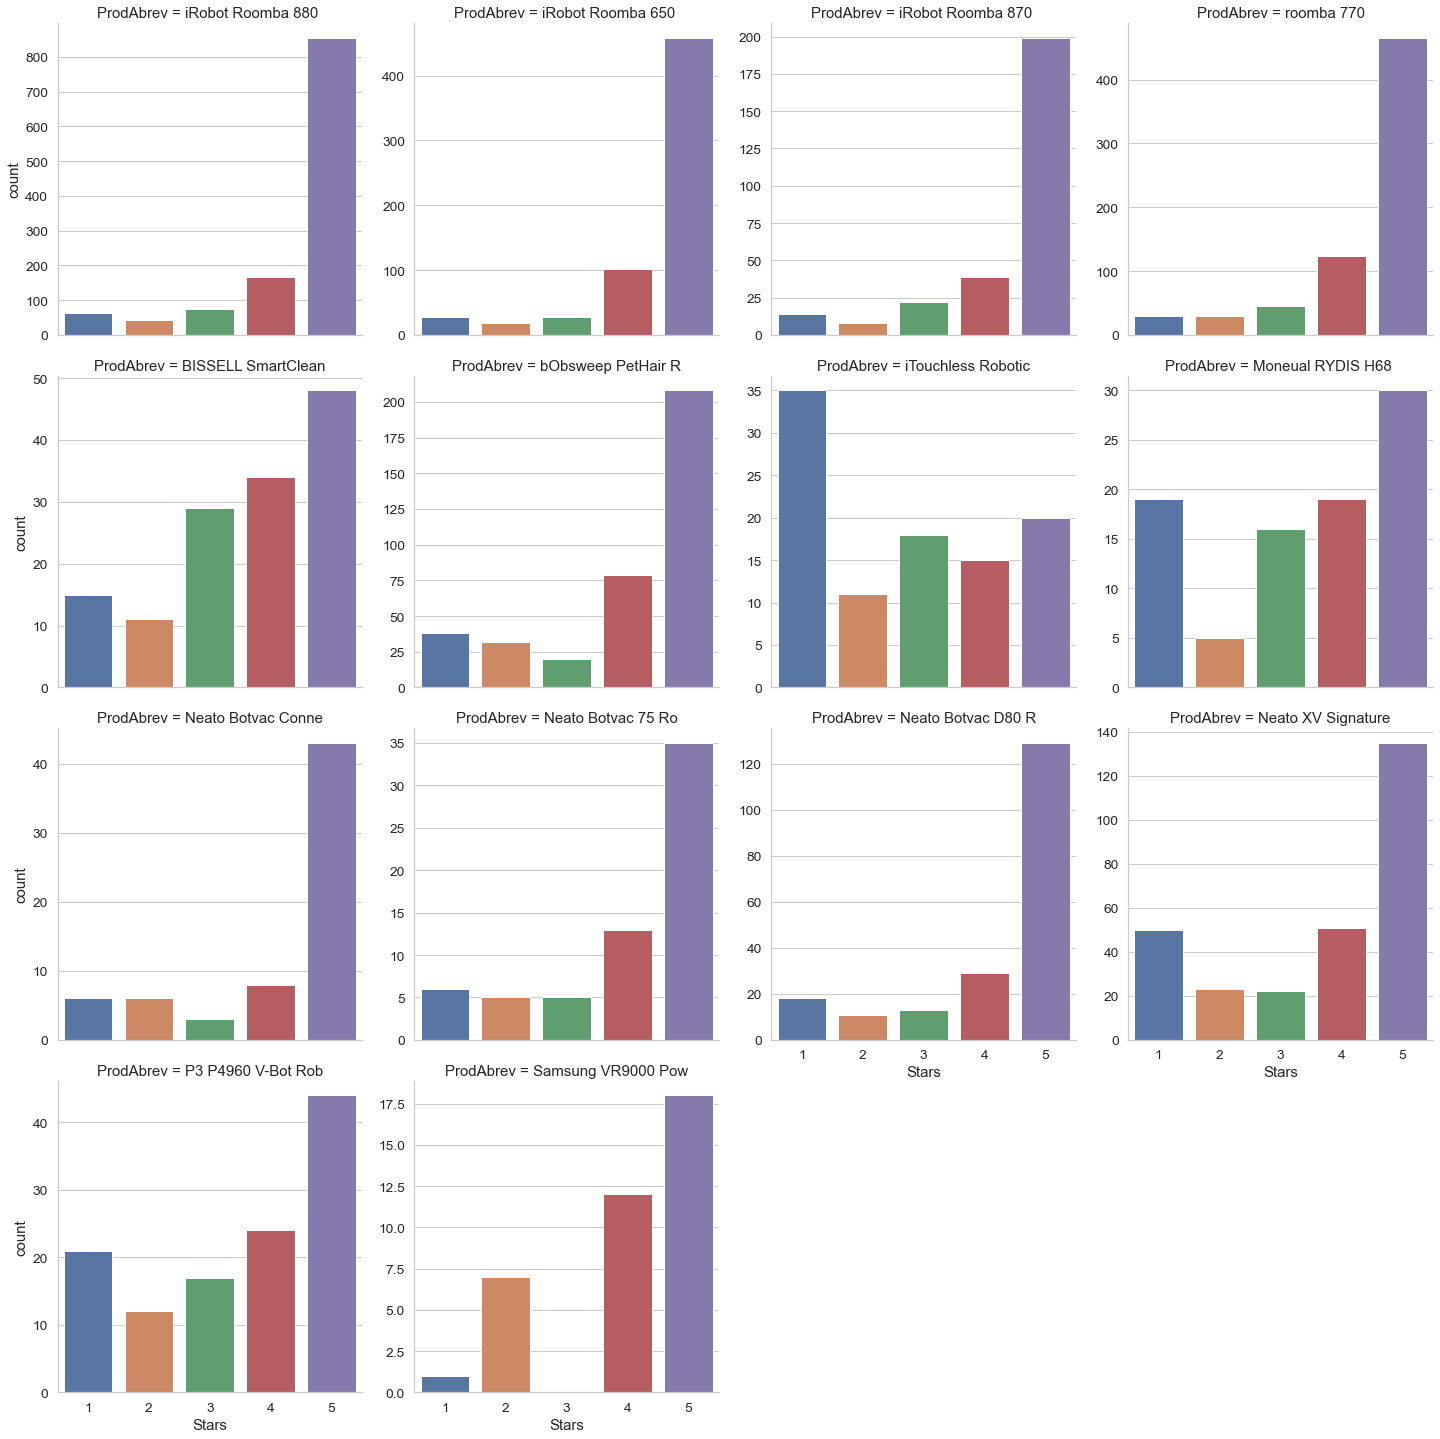

In [11]:
sns.catplot(x = 'Stars', 
            col = 'ProdAbrev', 
            kind = 'count', 
            col_wrap = 4, 
            sharey = False, # use free y-axis scales since counts vary by product
            data = rawDat.assign(ProdAbrev = lambda x: x.Product.str[:18]))

Most of the products recive many 5 star ratings. iTouchless Robotic seems recived many 1 star ratings. Nonetheless, these data are imbalanced. 

Now let's talk about prediction. Although we could analyze these ratings as they are (i.e., ordinal from 1 to 5), let's convert this outcome to binary data so that we can perform binary classification. We could choose to split the data as low ratings (e.g., 1-3) vs. high ratings (e.g., 4-5) based on Amazon's delineation; alternatively, we could only look at 1-star and 5-star reviews, although that would result in more data loss. For this example, let's go do the former:

In [12]:
rawDat['ReviewRating'] = np.where(rawDat.Stars >= 4, 'High', 'Low')

rawDat.groupby('ReviewRating').size()

ReviewRating
High    3401
Low      876
dtype: int64

<AxesSubplot:xlabel='ReviewRating', ylabel='count'>

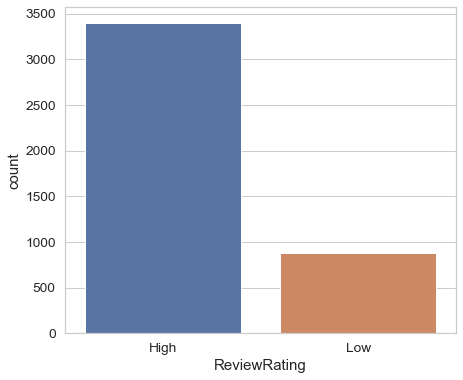

In [13]:
sns.countplot(x = 'ReviewRating', 
              data = rawDat)

Now we have a variable that can be used for binary classification -- albiet one with a class balance still skewed in favor of high reviews!

### Split Data

Now that we have our outcome variable, we can split the data set into training and testing data, assuming we want a holdout sample:

In [14]:
Train, Test = train_test_split(rawDat, 
                               stratify = rawDat.ReviewRating,
                               test_size = 0.20, 
                               random_state = 345)

### Class Balancing

While looking at our DV, we saw a clear class imbalance in the data, which also appears in the train/test data given that we used stratification:

In [15]:
display(Train.groupby('ReviewRating').size())
round(Train.groupby('ReviewRating').size()/len(Train), 3)

ReviewRating
High    2720
Low      701
dtype: int64

ReviewRating
High    0.795
Low     0.205
dtype: float64

Let's resolve this by downsampling the training data:

In [16]:
np.random.seed(345) # to create reproducible results

maj_class = np.where(Train.ReviewRating == 'High')[0]
min_class = np.where(Train.ReviewRating == 'Low')[0]

resample = np.random.choice(maj_class, size = len(min_class), replace = False)

TrainDS = pd.concat([Train.iloc[min_class], Train.iloc[resample]])

TrainDS.shape

(1402, 6)

### Feature Extraction

Unfortunately at this point, it looks like we don't have many data *features* (i.e., columns) to use for prediction:

In [17]:
TrainDS.sample()

,Date,Product,Stars,Title,Review,ReviewRating
3807,2015-12-03,Neato Botvac D80 Robot Vacuum for Pets and All...,3,Cleans very well. Just gets confused or wants ...,"First, I will admit I bought this through Best...",Low


In actuality, since some our columns involve text, we have a very feature rich data set despite seemingly having only a few columns to work with. The analysis of text data falls under the umbrella of *natural language processing (NLP)* or *text analytics*, and as such we'll need to do some additional work to make our data analyzable. Specifically, we need to take the raw reviews and convert them into analyzable data features for our machine learning (ML) models. For example, consider the following review from the data set:

In [18]:
print(TrainDS.Review.iloc[0])

Calling this thing garbage is an insult to garbage! It has so many major, inexcusable problems it practically begged for a terrible review.1. It returns to the dock, maybe 1 out of every 5 or 6 times. I have to search for it when it doesn't.2. When it's docked and you go to empty it, the dock connection disconnects and it starts to run because it's stupid.3. It randomly gets stuck and dies in place. It will drive into a corner or whatever and not be able to get out so it runs, hitting the objects until it dies. It appears it only 1/4 or so turns so it gets stuck in a lot of places because it over turns. It has no fine movement.4. It has very little power on carpets and so when it feels sluggish it backs up. When it does this it rides up the wall, door or whatever and gets stuck.5. There is absolutely no rhyme or reason to what it does. I have tried all the settings and it is so random in it's movement. For example it will go into a room and out of the room 3 times in a cycle and do the

While it's easy enough for us to read this review and determine if it will be associated with a high or low review score, we need to convert it to numeric data before our ML models can analyze it. One way to accomplish this involves generating a *term-document matrix (TDM)* from the reviews, which essentially tells us how frequently terms (e.g., words) are being used at the review-level. Conveniently, the sklearn package can accomplish this using a vectorizer as described [here](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction). In this case, we'll be using the [***CountVectorizer***](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) function to generate binary feature occurences for words that appear in at least 2.5% of the reviews (a setting that will need to be varied depending upon the dataset being analyzed) in the training data set:

In [20]:
vectorizer = CountVectorizer(analyzer = 'word', 
                             stop_words = 'english', 
                             min_df = .025, 
                             binary = True)

train_vectorizer_tdm = vectorizer.fit(TrainDS.Review.fillna(''))

train_tdm = pd.DataFrame(train_vectorizer_tdm.transform(TrainDS.Review.fillna('')).toarray(), columns = train_vectorizer_tdm.get_feature_names(), index = TrainDS.index)

train_tdm

,10,15,20,30,880,able,absolutely,actually,ago,amazing,...,wood,work,worked,working,works,worth,wouldn,year,years,yes
2931,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2161,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3740,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2719,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
666,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
3328,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
10,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In this DataFrame, the columns show the most common words used across reviews and the rows indicate whether a particular review contains a given word (where a `1` indicates the review does and a `0` indicates it does not).

Now let's merge our matrix with our other relevant data, using only the columns we want to include from the latter (i.e., ReviewRating [our DV], Date, and Product):

In [16]:
TrainDS_TDM = pd.concat([TrainDS[['ReviewRating', 'Date', 'Product']], train_tdm], axis = 1)

TrainDS_TDM

,ReviewRating,Date,Product,10,15,20,30,880,able,absolutely,...,wood,work,worked,working,works,worth,wouldn,year,years,yes
2931,Low,2016-01-09,BISSELL SmartClean 1605 Vacuum Cleaning Robot,0,0,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0
1017,Low,2015-04-23,iRobot Roomba 880 for Pets and Allergies,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2161,Low,2014-12-31,roomba 770,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3740,Low,2015-07-24,Neato Botvac D80 Robot Vacuum for Pets and All...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2719,Low,2015-08-21,roomba 770,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,High,2015-02-13,bObsweep PetHair Robotic Vacuum Cleaner and Mo...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
666,High,2015-06-12,iRobot Roomba 880 for Pets and Allergies,0,0,0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,0
3328,High,2014-12-19,iTouchless Robotic Intelligent Vacuum Cleaner PRO,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
10,High,2015-06-19,iRobot Roomba 880 for Pets and Allergies,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Note that for the "Date" column, some additional feature generation is also required, since its current format (i.e., year-month-day) is human-readable but not intelligible to our models. Conveniently, pandas [date functionality](https://pandas.pydata.org/docs/user_guide/timeseries.html) allows us to easily extract components of dates, such as day of the week (either numeric or as Monday, Tuesday, etc.), month label, etc. as well as more nuanced features such as weekend (or not), week number, and quarter. Let's explore a few simple options:

In [17]:
# note that there are many other options than those used below that may work better for certain data (e.g., categorical month labels)

TrainDS_TDM_Date = TrainDS_TDM.copy()

TrainDS_TDM_Date['Date_Year'] = TrainDS_TDM.Date.dt.year
TrainDS_TDM_Date['Date_Month'] = TrainDS_TDM.Date.dt.month
TrainDS_TDM_Date['Date_Day'] = TrainDS_TDM.Date.dt.day

TrainDS_TDM_Date['Date_DayOfWeek'] = TrainDS_TDM.Date.dt.dayofweek
TrainDS_TDM_Date['Date_WeekOfYear'] = TrainDS_TDM.Date.dt.isocalendar().week

TrainDS_TDM_Date['Date_IsWeekend'] = np.where(TrainDS_TDM_Date['Date_DayOfWeek'] >= 5, 1, 0)

TrainDS_TDM_Date.drop(columns = 'Date', inplace = True)

TrainDS_TDM_Date

,ReviewRating,Product,10,15,20,30,880,able,absolutely,actually,...,wouldn,year,years,yes,Date_Year,Date_Month,Date_Day,Date_DayOfWeek,Date_WeekOfYear,Date_IsWeekend
2931,Low,BISSELL SmartClean 1605 Vacuum Cleaning Robot,0,0,0,0,0,1,1,0,...,0,0,0,0,2016,1,9,5,1,1
1017,Low,iRobot Roomba 880 for Pets and Allergies,0,0,0,0,0,0,0,0,...,0,0,0,0,2015,4,23,3,17,0
2161,Low,roomba 770,0,0,0,0,0,0,0,0,...,0,0,0,0,2014,12,31,2,1,0
3740,Low,Neato Botvac D80 Robot Vacuum for Pets and All...,0,0,0,0,0,0,0,0,...,0,0,0,0,2015,7,24,4,30,0
2719,Low,roomba 770,0,0,0,0,0,0,0,0,...,0,0,0,0,2015,8,21,4,34,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,High,bObsweep PetHair Robotic Vacuum Cleaner and Mo...,0,0,0,0,0,0,0,0,...,0,0,0,0,2015,2,13,4,7,0
666,High,iRobot Roomba 880 for Pets and Allergies,0,0,0,0,1,0,0,0,...,1,0,0,0,2015,6,12,4,24,0
3328,High,iTouchless Robotic Intelligent Vacuum Cleaner PRO,0,0,0,0,0,0,0,0,...,0,0,0,0,2014,12,19,4,51,0
10,High,iRobot Roomba 880 for Pets and Allergies,0,0,0,0,0,0,0,0,...,0,0,1,0,2015,6,19,4,25,0


Let's also apply this TDM generation based on the training data to the test data:

In [18]:
# create TDM features

test_tdm = pd.DataFrame(train_vectorizer_tdm.transform(Test.Review.fillna('')).toarray(), columns = train_vectorizer_tdm.get_feature_names_out(), index = Test.index)

Test_TDM = pd.concat([Test[['ReviewRating', 'Date', 'Product']], test_tdm], axis = 1)

# create date features

Test_TDM_Date = Test_TDM.copy()

Test_TDM_Date['Date_Year'] = Test_TDM_Date.Date.dt.year
Test_TDM_Date['Date_Month'] = Test_TDM_Date.Date.dt.month
Test_TDM_Date['Date_Day'] = Test_TDM_Date.Date.dt.day

Test_TDM_Date['Date_DayOfWeek'] = Test_TDM_Date.Date.dt.dayofweek
Test_TDM_Date['Date_WeekOfYear'] = Test_TDM_Date.Date.dt.isocalendar().week

Test_TDM_Date['Date_IsWeekend'] = np.where(Test_TDM_Date['Date_DayOfWeek'] >= 5, 1, 0)

Test_TDM_Date.drop(columns = 'Date', inplace = True)

Test_TDM_Date

,ReviewRating,Product,10,15,20,30,880,able,absolutely,actually,...,wouldn,year,years,yes,Date_Year,Date_Month,Date_Day,Date_DayOfWeek,Date_WeekOfYear,Date_IsWeekend
827,Low,iRobot Roomba 880 for Pets and Allergies,0,0,0,0,0,0,0,0,...,0,0,0,0,2015,2,7,5,6,1
3535,High,Neato Botvac Connected Wi-Fi Enabled Robot Vacuum,0,0,0,0,0,0,0,0,...,0,0,0,0,2015,11,26,3,48,0
3300,High,bObsweep PetHair Robotic Vacuum Cleaner and Mo...,0,0,0,0,0,0,0,0,...,0,0,0,0,2015,11,15,6,46,1
4089,Low,Neato XV Signature Pro Pet,0,0,0,0,0,0,0,0,...,0,0,0,0,2015,4,29,2,18,0
3445,Low,Moneual RYDIS H68 Pro RoboVacMop Hybrid Robot ...,0,0,0,0,0,0,0,0,...,0,0,0,0,2015,12,23,2,52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,High,iRobot Roomba 880 for Pets and Allergies,0,0,0,0,0,0,0,0,...,0,0,0,0,2014,9,24,2,39,0
508,High,iRobot Roomba 880 for Pets and Allergies,0,0,0,0,0,0,0,0,...,0,0,0,0,2015,7,21,1,30,0
1925,Low,iRobot Roomba 870 Vacuum Cleaning Robot For Pe...,0,0,0,0,0,0,0,0,...,0,0,0,0,2016,1,6,2,1,0
1312,High,iRobot Roomba 650 for Pets,0,0,0,0,0,0,0,0,...,0,0,0,0,2015,9,29,1,40,0


That takes care of feature engineering the reviews.

Before moving on, it's worth noting that we could have also incorporated the review titles (i.e., Title) into our analysis by creating a separate TDM for them. For this example, we're ignoring these additional features to streamline the process.

### Preprocessing

At this point, we're ready to do some basic preprocessing and checks to ensure our data will suit our models. First, let's consider missing data:

In [19]:
round(1 - len(TrainDS_TDM_Date.dropna())/len(TrainDS_TDM_Date), 3)

0.0

No missing data to worry about here thankfully. Next let's take care of one hot encoding the categorical data (e.g., Product):

In [20]:
enc = OneHotEncoder(handle_unknown = 'ignore', 
                    sparse = False)

enc_raw_data_train = TrainDS_TDM_Date.drop(columns = 'ReviewRating').select_dtypes(include = ['object', 'category'])

enc = enc.fit(enc_raw_data_train)

encoded_data_train = pd.DataFrame(enc.transform(enc_raw_data_train))

encoded_data_train.columns = enc.get_feature_names_out(enc_raw_data_train.columns)
encoded_data_train.index = enc_raw_data_train.index

TrainDS_TDM_Date_Enc = pd.concat([TrainDS_TDM_Date.drop(enc_raw_data_train.columns, axis = 1), encoded_data_train], axis = 1)

TrainDS_TDM_Date_Enc.head()

,ReviewRating,10,15,20,30,880,able,absolutely,actually,ago,...,Product_Neato Botvac D80 Robot Vacuum for Pets and Allergies,Product_Neato XV Signature Pro Pet,Product_P3 P4960 V-Bot Robotic Vacuum Cleaner,"Product_Samsung VR9000 Powerbot Robotic Vacuum, Airborne Copper","Product_bObsweep PetHair Robotic Vacuum Cleaner and Mop, Rouge",Product_iRobot Roomba 650 for Pets,Product_iRobot Roomba 870 Vacuum Cleaning Robot For Pets and Allergies,Product_iRobot Roomba 880 for Pets and Allergies,Product_iTouchless Robotic Intelligent Vacuum Cleaner PRO,Product_roomba 770
2931,Low,0,0,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1017,Low,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2161,Low,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3740,Low,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2719,Low,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Let's also do zero variance (ZV) removal just in case (although there shouldn't be any at this point):

In [21]:
selector = VarianceThreshold()

sel_raw_data_train = TrainDS_TDM_Date_Enc.drop(columns = 'ReviewRating')

selector = selector.fit(sel_raw_data_train)

selected_data_train = sel_raw_data_train.iloc[:, selector.get_support(indices = True)]

TrainDS_TDM_Date_EncSel = pd.concat([TrainDS_TDM_Date_Enc.drop(sel_raw_data_train.columns, axis = 1), selected_data_train], axis = 1)

TrainDS_TDM_Date_EncSel.head()

,ReviewRating,10,15,20,30,880,able,absolutely,actually,ago,...,Product_Neato Botvac D80 Robot Vacuum for Pets and Allergies,Product_Neato XV Signature Pro Pet,Product_P3 P4960 V-Bot Robotic Vacuum Cleaner,"Product_Samsung VR9000 Powerbot Robotic Vacuum, Airborne Copper","Product_bObsweep PetHair Robotic Vacuum Cleaner and Mop, Rouge",Product_iRobot Roomba 650 for Pets,Product_iRobot Roomba 870 Vacuum Cleaning Robot For Pets and Allergies,Product_iRobot Roomba 880 for Pets and Allergies,Product_iTouchless Robotic Intelligent Vacuum Cleaner PRO,Product_roomba 770
2931,Low,0,0,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1017,Low,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2161,Low,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3740,Low,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2719,Low,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Finally, let's go ahead and scale our variables since some are not binary (i.e., the ones related to the date) and on very different scales, which may influence some of our model results:

In [22]:
TrainDS_TDM_Date_EncSel.filter(like = 'Date_')

,Date_Year,Date_Month,Date_Day,Date_DayOfWeek,Date_WeekOfYear,Date_IsWeekend
2931,2016,1,9,5,1,1
1017,2015,4,23,3,17,0
2161,2014,12,31,2,1,0
3740,2015,7,24,4,30,0
2719,2015,8,21,4,34,0
...,...,...,...,...,...,...
3309,2015,2,13,4,7,0
666,2015,6,12,4,24,0
3328,2014,12,19,4,51,0
10,2015,6,19,4,25,0


In this example, we will apply scaling to all our variables -- including binary/dummy variables -- although this may not be ideal or necessary in terms of achieving optimal results. There are many possibilities on how to perform the scaling provided by sklearn as discussed in the user guide [here](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling), although in this case we'll use the [***RobustScaler***](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) to streamline this example, since it will leave binary data columns untouched:

In [23]:
scaler = RobustScaler()

sca_raw_data_train = TrainDS_TDM_Date_EncSel.drop(columns = 'ReviewRating').select_dtypes(exclude = ['object', 'category'])

scaler = scaler.fit(sca_raw_data_train)

scaled_data_train = pd.DataFrame(scaler.transform(sca_raw_data_train))

scaled_data_train.columns = sca_raw_data_train.columns
scaled_data_train.index = sca_raw_data_train.index

TrainDS_TDM_Date_EncSelSca = pd.concat([TrainDS_TDM_Date_EncSel.drop(sca_raw_data_train.columns, axis = 1), scaled_data_train], axis = 1)

TrainDS_TDM_Date_EncSelSca.head()

,ReviewRating,10,15,20,30,880,able,absolutely,actually,ago,...,Product_Neato Botvac D80 Robot Vacuum for Pets and Allergies,Product_Neato XV Signature Pro Pet,Product_P3 P4960 V-Bot Robotic Vacuum Cleaner,"Product_Samsung VR9000 Powerbot Robotic Vacuum, Airborne Copper","Product_bObsweep PetHair Robotic Vacuum Cleaner and Mop, Rouge",Product_iRobot Roomba 650 for Pets,Product_iRobot Roomba 870 Vacuum Cleaning Robot For Pets and Allergies,Product_iRobot Roomba 880 for Pets and Allergies,Product_iTouchless Robotic Intelligent Vacuum Cleaner PRO,Product_roomba 770
2931,Low,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1017,Low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2161,Low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3740,Low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2719,Low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Notice how this scaling has affected the date columns:

In [24]:
TrainDS_TDM_Date_EncSelSca.filter(like = 'Date_')

,Date_Year,Date_Month,Date_Day,Date_DayOfWeek,Date_WeekOfYear,Date_IsWeekend
2931,1.0,-1.000000,-0.3750,0.50,-1.107143,1.0
1017,0.0,-0.571429,0.5000,0.00,-0.535714,0.0
2161,-1.0,0.571429,1.0000,-0.25,-1.107143,0.0
3740,0.0,-0.142857,0.5625,0.25,-0.071429,0.0
2719,0.0,0.000000,0.3750,0.25,0.071429,0.0
...,...,...,...,...,...,...
3309,0.0,-0.857143,-0.1250,0.25,-0.892857,0.0
666,0.0,-0.285714,-0.1875,0.25,-0.285714,0.0
3328,-1.0,0.571429,0.2500,0.25,0.678571,0.0
10,0.0,-0.285714,0.2500,0.25,-0.250000,0.0


Now let's apply the relevant steps to the test data as well using the training methods to fulfill the process:

In [25]:
# one hot encoding

enc_raw_data_test = Test_TDM_Date.drop(columns = 'ReviewRating').select_dtypes(include = ['object', 'category'])

encoded_data_test = pd.DataFrame(enc.transform(enc_raw_data_test))

encoded_data_test.columns = enc.get_feature_names_out(enc_raw_data_test.columns)
encoded_data_test.index = enc_raw_data_test.index

Test_TDM_Date_Enc = pd.concat([Test_TDM_Date.drop(enc_raw_data_test.columns, axis = 1), encoded_data_test], axis = 1)

# scaling

sca_raw_data_test = Test_TDM_Date_Enc.drop(columns = 'ReviewRating')

scaled_data_test = pd.DataFrame(scaler.transform(sca_raw_data_test))

scaled_data_test.columns = sca_raw_data_test.columns
scaled_data_test.index = sca_raw_data_test.index

Test_TDM_Date_EncSca = pd.concat([Test_TDM_Date_Enc.drop(sca_raw_data_test.columns, axis = 1), scaled_data_test], axis = 1)

# final result

Test_TDM_Date_EncSca.head()

,ReviewRating,10,15,20,30,880,able,absolutely,actually,ago,...,Product_Neato Botvac D80 Robot Vacuum for Pets and Allergies,Product_Neato XV Signature Pro Pet,Product_P3 P4960 V-Bot Robotic Vacuum Cleaner,"Product_Samsung VR9000 Powerbot Robotic Vacuum, Airborne Copper","Product_bObsweep PetHair Robotic Vacuum Cleaner and Mop, Rouge",Product_iRobot Roomba 650 for Pets,Product_iRobot Roomba 870 Vacuum Cleaning Robot For Pets and Allergies,Product_iRobot Roomba 880 for Pets and Allergies,Product_iTouchless Robotic Intelligent Vacuum Cleaner PRO,Product_roomba 770
827,Low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3535,High,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3300,High,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4089,Low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3445,Low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model Fitting

We're now ready to fit our models. We'll be using the following models in this analysis:

1. Decision Tree
2. AdaBoost
3. Random Forest
4. Support Vector (Linear)
5. Logistic Regression (Lasso/Ridge Regularized)

As usual, we'll be exploring various hyperparameters as part of model tuning.

In [26]:
# set up data and labels
X_train = TrainDS_TDM_Date_EncSelSca.drop(columns = 'ReviewRating')
y_train = TrainDS_TDM_Date_EncSelSca.ReviewRating

X_test = Test_TDM_Date_EncSca.drop(columns = 'ReviewRating')
y_test = Test_TDM_Date_EncSca.ReviewRating

pos_label = 'High'

# set up scoring metric
scoring_metric = 'balanced_accuracy'

# set up classifiers and tuning parameters
names = ['Decision Tree', 'AdaBoost', 'Random Forest', 'Linear SVM', 'Logistic Regression']
classifiers = [DecisionTreeClassifier(random_state = 345), 
               AdaBoostClassifier(random_state = 345), 
               RandomForestClassifier(random_state = 345), 
               SVC(random_state = 345, kernel = 'linear', probability = True), 
               LogisticRegression(random_state = 345, solver = 'liblinear')]
param_grids = [{'max_depth': [2, 3, 4, 5, 10, 15], 'criterion': ['gini', 'entropy']},
               {'n_estimators': [50, 100, 200]},
               {'max_depth': [2, 3, 4], 'max_features': [None, 'sqrt', 'log2'], 'n_estimators': [50, 100, 200]},
               {'C': [0.01, 0.25, 0.5, 1, 2]}, 
               {'penalty': ['l1', 'l2']}]

# create empty lists for storing outcomes
models = []
preds = []
probs = []
BAs = []
AUCs = []
FPRs = []
TPRs = []
timings = []

# train classifiers and generate test predictions/probabilities
for i, eachClassifier in enumerate(classifiers):
    
    print('Now working on model ', i + 1, ' of ', len(classifiers), ': ', names[i], sep = '')
    
    # define cross-validation/parameter tuning settings
    search = GridSearchCV(eachClassifier, 
                          param_grids[i], 
                          cv = 5, # using (Stratified)KFold by default (with 5 folds)
                          scoring = scoring_metric,
                          n_jobs = -1) # use parallel processing
    
    model = search.fit(X_train, y_train)
    pred = search.predict(X_test)
    prob = search.predict_proba(X_test)[:, 1]
    
    models.append(model)
    preds.append(pred)
    probs.append(prob)
    
    BAs.append(balanced_accuracy_score(y_test, pred))
    AUCs.append(roc_auc_score(y_test, prob))
    
    FPR, TPR, _ = roc_curve(y_test, prob, pos_label = pos_label)
    
    FPRs.append(FPR)
    TPRs.append(TPR)
    
    timings.append(model.refit_time_)
    
print('Finished!')

Now working on model 1 of 5: Decision Tree
Now working on model 2 of 5: AdaBoost
Now working on model 3 of 5: Random Forest
Now working on model 4 of 5: Linear SVM
Now working on model 5 of 5: Logistic Regression
Finished!


### Evaluation

Now let's pull up our results sorted by AUC to choose our best model:

In [27]:
results = pd.DataFrame({'Classifier': names, 
                        'Balanced Accuracy': BAs, 
                        'AUC': AUCs, 
                        'TPR': TPRs, 
                        'FPR': FPRs, 
                        'Refit Time': timings}).sort_values('AUC', ascending = False)

display(round(results[['Classifier', 'Refit Time', 'Balanced Accuracy', 'AUC']], 3))

,Classifier,Refit Time,Balanced Accuracy,AUC
2,Random Forest,0.305,0.787,0.865
3,Linear SVM,1.460,0.788,0.864
1,AdaBoost,0.616,0.795,0.860
4,Logistic Regression,0.025,0.772,0.855
0,Decision Tree,0.069,0.669,0.709


We can also compare the models visually:

/var/folders/g0/w4d4cqfj3cgchjzwlrlfdj740000gq/T/ipykernel_75058/1770620105.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.figure.colorbar(smRTs)


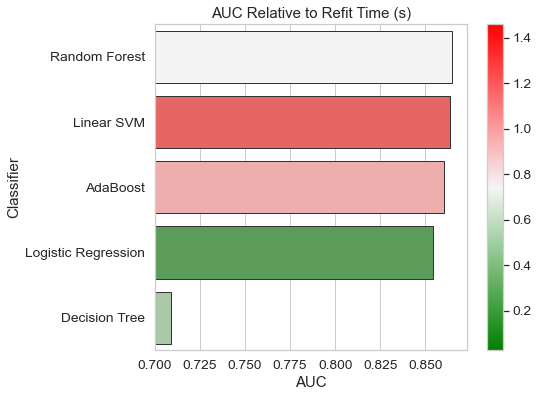

In [28]:
greenToRed = LinearSegmentedColormap.from_list('', ['green', 'whitesmoke', 'red'])
cm.register_cmap('green_to_red', greenToRed)

normRTs = plt.Normalize(results['Refit Time'].min(), results['Refit Time'].max())
smRTs = plt.cm.ScalarMappable(cmap = 'green_to_red', norm = normRTs)

ax = sns.barplot(y = 'Classifier', 
                 x = 'AUC', 
                 hue = 'Refit Time', 
                 dodge = False, 
                 palette = 'green_to_red', 
                 edgecolor = '.2', 
                 data = results)

ax.get_legend().remove()
ax.figure.colorbar(smRTs)
ax.set(title = 'AUC Relative to Refit Time (s)')
ax.set(xlim = (math.floor(results.AUC.min() * 10) * 10/100, 
               results.AUC.max() * 1.01))

plt.show()

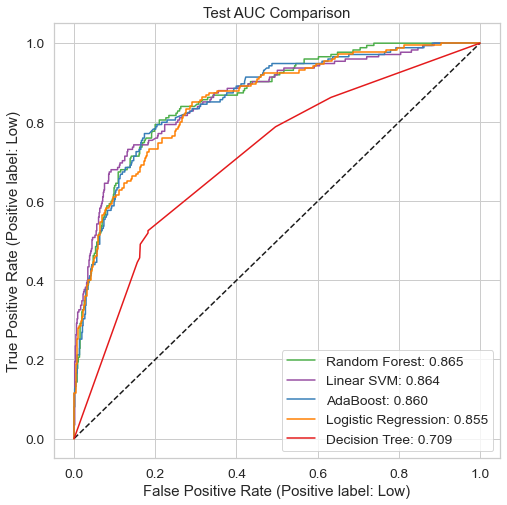

In [29]:
# defining a custom function for reuse later
def Custom_ROC_Plot (results, X_test, y_test, title, figwidth = 8, figheight = 8):

    fig, ax = plt.subplots(figsize = (figwidth, figheight))

    ax.plot(ax.get_xlim(), ax.get_ylim(), ls = '--', c = 'k')
    ax.set(title = title)

    for i in results.index:
        RocCurveDisplay.from_estimator(models[i], 
                                       X_test, 
                                       y_test, 
                                       color = cm.Set1(i), 
                                       label = results.loc[i, 'Classifier'] + ': {:.3f}'.format(results.loc[i, 'AUC']),  
                                       ax = ax)
        
    return([fig, ax])

fig, ax = Custom_ROC_Plot(results, X_test, y_test, title = 'Test AUC Comparison')

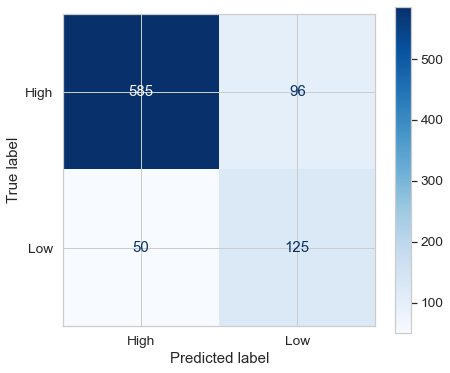

In [30]:
best_index = results.index[0]

# note: for a simple printed matrix, you can use:
# confusion_matrix(y_test, preds[best_index])

ConfusionMatrixDisplay.from_estimator(models[best_index], 
                                      X_test, 
                                      y_test,
                                      cmap = plt.cm.Blues,
                                      values_format = 'd')

In [31]:
print(classification_report(y_test, preds[best_index], digits = 3))

              precision    recall  f1-score   support

        High      0.921     0.859     0.889       681
         Low      0.566     0.714     0.631       175

    accuracy                          0.829       856
   macro avg      0.743     0.787     0.760       856
weighted avg      0.849     0.829     0.836       856



<AxesSubplot:xlabel='importance', ylabel='feature'>

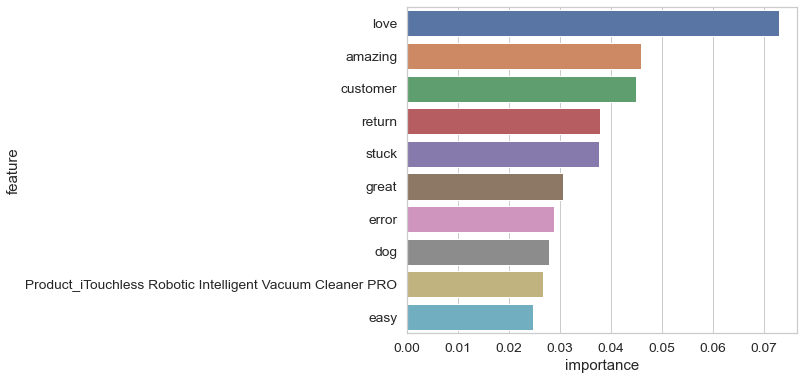

In [32]:
# for models with feature importances
if hasattr(models[best_index].best_estimator_, 'feature_importances_'):
    var_imp = pd.DataFrame({
        'feature': X_test.columns, 
        'importance': models[best_index].best_estimator_.feature_importances_}).sort_values('importance', ascending = False)
# for models with coefficients (directional) -- note: for interpretation and potential caveats, see https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html
elif hasattr(models[best_index].best_estimator_, 'coef_'):
    var_imp = pd.DataFrame({
        'feature': X_test.columns, 
        'importance_abs': abs(models[best_index].best_estimator_.coef_[0]), 
        'importance': models[best_index].best_estimator_.coef_[0]}).sort_values('importance_abs', ascending = False)
    
sns.barplot(y = 'feature', 
            x = 'importance', 
            data = var_imp.head(10))

If desired, we could look at the effect of some of these words in the context of the reviews by searching them for specific words of interest:

In [33]:
review_love = Test[Test.Review.str.contains('love', case = False, na = False)][['Title', 'Review', 'Stars', 'ReviewRating']]

display(review_love.sample(10))

print('Mean Score:', round(np.mean(review_love.Stars), 3))

print('Sample High Review:', review_love.query('ReviewRating == "High"')['Review'].iloc[0]) # show 1 high review from the top

,Title,Review,Stars,ReviewRating
1602,Great for cat owners!!,The robot picks up TONS of cat hair and vacuum...,5,High
804,Well worth the price!,I LOVE my Roomba! I've had it about a month a...,5,High
2224,We Love Our Roomba - Even When It Gets Confused,We've lived with our pet Roomba now for about ...,4,High
656,this thing is fantastic. However,"In theory, this thing is fantastic. However, ...",3,Low
2903,Great product,I love the Bissell Smartclean. It works really...,5,High
1430,BEST!!!!,"Top ten purchases EVER made!!! Have 2 dogs, a ...",5,High
777,Highly recommend!,I love this thing. it does a great job of pic...,5,High
1186,No More Vacuuming,Absolutely love this Roomba. We have not vacuu...,5,High
4098,SWEET! Worth working overtime to pay for it,SWEET! Worth working overtime to pay for it. I...,5,High
4224,Four Stars,I love it!!,4,High


Mean Score: 4.646
Sample High Review: Nickname: Deathstar.Mission: To destroy all dust rebels in the home.The Neato Botvac Connected requires very little assembly and minor setup.1. Unpack your Neato.2. Pull out the little tab and turn the Neato on.3. Plug in the charging station and put the Neato up against it until the little lights flash.4. Download the Neato app, which is called 'Neato Robotics' and currently is "neato" on a white background.5. Enter the serial number off the bottom of the Neato to add it to the app.6. Set a schedule! Sit back! Relax! Because the Neato has you covered.Ok, so it's clear, this thing does run completely on its own... but it gets stuck. It's so powerful it can go over things like the feet of an electric piano bench, but it can't get itself off. It also gets stuck on beanie babies. So while you can set it to run while you are away, unless you confine it to a small area that is Neato-proofed it will get stuck and continue to beep until you free it. If yo

In [34]:
review_return = Test[Test.Review.str.contains('return', case = False, na = False)][['Title', 'Review', 'Stars', 'ReviewRating']]

display(review_return.sample(10))

print('Mean Score:', round(np.mean(review_return.Stars), 3))

print('Sample Low Review:', review_return.query('ReviewRating == "Low"')['Review'].iloc[0]) # show 1 low review from the top

,Title,Review,Stars,ReviewRating
3512,"Totally inconsistent, coolness factor overwhel...",Weird thing- to set the time if you aren't usi...,3,Low
324,"Love it, Would buy this product again.",The Roomba 880 is certainly a nice upgrade fro...,5,High
1529,Waste of Money,This is supposed to clean dog hair and clean y...,2,Low
3569,Impressive robot and great vacuum,EDIT:I'm changing my review to 5 stars. You ca...,5,High
2011,Amazing Cleaning Machine,I ordered this item as I am never home to clea...,5,High
2993,I bought a Bobsweep and it made me really want...,UPDATE: I've upped my rating to two stars. Al...,2,Low
4013,Highly recommend the Neato XV Signature Pro,This robot vacuum does an excellent job pickin...,5,High
927,"Love it, but Cost/Value 👎🏼",I bought the 650 and had it for a week before ...,4,High
449,great in principle. lacking execution.,Originally the 770 but found that the brushes ...,3,Low
3207,Don't buy,I bought the PetHair model from Groupon. In r...,1,Low


Mean Score: 3.524
Sample Low Review: I just received this unit and opened it to find, to my horror, that the unit was FILTHY, clogged with long, black hair and the collection bin was filled with cat dander and dust, which immediately activated my allergies, causing my face to swell and my vision to blur. There is nothing on this product listing that suggested this would be a rejected item, and -- let me be clear -- this is NOT a "refurbished" item. There were fingerprints all over the cover as well as the filth on the outside and the hair/dander inside.I'll be returning this item, filing a complaint against the merchant and buying a unit directly from iRobot to try out what looks like a neat technology. Shame on Amazon for letting this happen!!!


We could also look at some of the top features statistically in a simple, follow-up regression model (using R's effects package for plotting). First, let's programmatically create a formula using the top five features as main effects:

In [35]:
# note: we will title case all the features to avoid issues with certain names (e.g., 'return' causes problems)

formula = 'ReviewRating ~ ' + var_imp.feature.head(5).str.title().str.cat(sep = ' + ')

formula

'ReviewRating ~ Love + Amazing + Customer + Return + Stuck'

Next, let's create a TDM for the original, non-downsampled training data:

In [36]:
train_tdm = pd.DataFrame(train_vectorizer_tdm.transform(Train.Review.fillna('')).toarray(), columns = train_vectorizer_tdm.get_feature_names_out(), index = Train.index)

train_tdm.columns = map(str.title, train_tdm.columns) # title case column names as per above

Train_TDM = pd.concat([Train[['ReviewRating', 'Product']], train_tdm], axis = 1)

Now let's use this to run a GLM in Python:

In [37]:
mod1 = smf.glm(formula = formula, data = Train_TDM, family = sm.families.Binomial()).fit()

mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              Generalized Linear Model Regression Results                              
=======================================================================================================
Dep. Variable:     ['ReviewRating[High]', 'ReviewRating[Low]']   No. Observations:                 3421
Model:                                                     GLM   Df Residuals:                     3415
Model Family:                                         Binomial   Df Model:                            5
Link Function:                                           Logit   Scale:                          1.0000
Method:                                                   IRLS   Log-Likelihood:                -1517.7
Date:                                         Tue, 30 Nov 2021   Deviance:                       3035.4
Time:                                                 20:19:15   Pearson chi2:                 3.28e+03
No. Iterations:                                              6   Pseudo R-squ. (CS):             0.1192
Covariance Type:                                     nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3918      0.054     25.656      0.000       1.286       1.498
Love           1.9103      0.192      9.935      0.000       1.533       2.287
Amazing        2.0067      0.311      6.458      0.000       1.398       2.616
Customer      -1.7856      0.199     -8.961      0.000      -2.176      -1.395
Return        -1.2274      0.178     -6.896      0.000      -1.576      -0.879
Stuck         -0.8422      0.110     -7.646      0.000      -1.058      -0.626
==============================================================================
"""

Unsurprisingly every term is significant. Now let's re-run this with R and plot the effects:

In [38]:
from rpy2.robjects.packages import importr
from rpy2 import robjects
from rpy2.robjects import pandas2ri

base = importr('base')
stats = importr('stats')
effects = importr('effects')

df = robjects.r('data.frame')
coef = robjects.r('coef')

pandas2ri.activate() # let's use our existing Python data instead of loading the carData package in R data
robjects.globalenv['Train_TDM'] = Train_TDM

robjects.r('Train_TDM$ReviewRating <- factor(Train_TDM$ReviewRating, levels = c("Low", "High"))')

mod1R = stats.glm(formula, data = robjects.globalenv['Train_TDM'], family = 'binomial')

Now we can look at some effect plots:

,Love,fit,se,lower,upper
1,Not Mentioned,0.781860,0.008690,0.764349,0.798413
2,Mentioned,0.960337,0.007168,0.943643,0.972232


<AxesSubplot:xlabel='Love', ylabel='High Review Probability'>

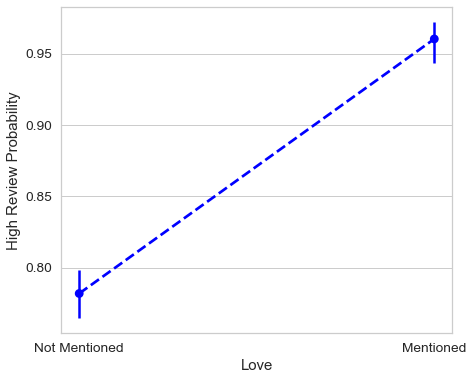

In [39]:
# love

# define colors
cust_colors = np.array(['blue'])
sns.set_palette(cust_colors)

# define variables
xVar = 'Love'

robjects.r('Train_TDM$' + xVar + ' <- factor(Train_TDM$' + xVar + ')')

mod1R = stats.glm(formula, data = robjects.globalenv['Train_TDM'], family = 'binomial')

plotEffect = df(effects.effect(xVar, mod1R))

plotEffect[xVar] = plotEffect[xVar].replace({'0': 'Not Mentioned', '1': 'Mentioned'})

display(plotEffect.head())

fig = sns.pointplot(x = xVar, 
                    y = 'fit', 
                    linestyles = '--', 
                    data = plotEffect)

plt.vlines(x = xVar, 
           ymin = 'lower', 
           ymax = 'upper', 
           color = cust_colors, 
           linewidth = 2.5, 
           data = plotEffect)

fig.set(ylabel = 'High Review Probability')

fig

,Return,fit,se,lower,upper
1,Not Mentioned,0.846695,0.007515,0.831379,0.860853
2,Mentioned,0.618109,0.040755,0.535722,0.694221


<AxesSubplot:xlabel='Return', ylabel='High Review Probability'>

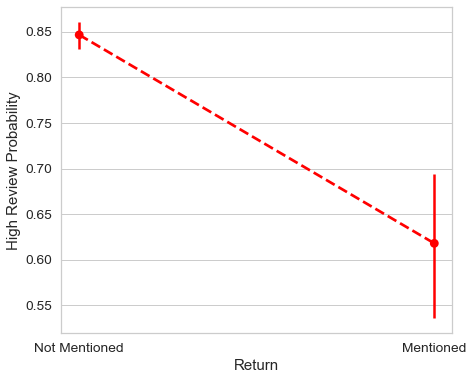

In [40]:
# return

# define colors
cust_colors = np.array(['red'])
sns.set_palette(cust_colors)

# define variables
xVar = 'Return'

robjects.r('Train_TDM$' + xVar + ' <- factor(Train_TDM$' + xVar + ')')

mod1R = stats.glm(formula, data = robjects.globalenv['Train_TDM'], family = 'binomial')

plotEffect = df(effects.effect(xVar, mod1R))

plotEffect[xVar] = plotEffect[xVar].replace({'0': 'Not Mentioned', '1': 'Mentioned'})

display(plotEffect.head())

fig = sns.pointplot(x = xVar, 
                    y = 'fit', 
                    linestyles = '--', 
                    data = plotEffect)

plt.vlines(x = xVar, 
           ymin = 'lower', 
           ymax = 'upper', 
           color = cust_colors, 
           linewidth = 2.5, 
           data = plotEffect)

fig.set(ylabel = 'High Review Probability')

fig

### Write Up  <a class="anchor" id="Write-Up"></a>
We tried 5 machine learning model to classify positive and negative Amazon product reviews. Random Forest is the best model based on AUC score. The accuracy of the model is 82.9%. Top 7 important words to help the model classify are love, amazing, customer, return, stuck, great, and error. Furthermore,  the average rating of reviews contains 'love' is 4.646. The average rating of reviews contains 'return' is 3.524. Based on results of regression model, when the review contains the word 'love' or  'amazing', It is more likely to be a high rating; When the review contains the world 'Customer', 'Return', 'Stuck', it is more likely to be a low rating.